# X-means sample 

In [ ]:
!pip install pyclustering

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.gmeans import gmeans

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

# Read sample 'simple3' from file.
sample = read_sample(SIMPLE_SAMPLES.SAMPLE_SIMPLE3)

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

# Get pentad rainfall data

In [ ]:
import numpy as np
import os

path = 'data/'
image_folder = 'CHIRPS_SPI_4pentads/'
lon = np.genfromtxt( path + "AOI_longitude.csv", delimiter=',')
lat = np.genfromtxt( path + "AOI_latitude.csv", delimiter=',')
    
files_raw = np.array(os.listdir(path + image_folder))
if '.DS_Store' in files_raw:    
    files = np.delete( files_raw, np.where(files_raw == '.DS_Store')[0][0] )
else:
    files = files_raw
files = np.sort(files)
ymp = [ (f.split('_')[1][1:5],  f.split('_')[1].split('m')[1].split('p')[0] ,
            f.split('_')[1].split('m')[1].split('p')[1])  for f in files]
image_arr = np.array([ np.genfromtxt( path + image_folder + f, delimiter=',') for f in files])
# image_arr_reshaped = np.transpose(image_arr, (1,2,0))

data_dict = {'latitude': lat,
        'longitude':lon,
        'imagearray': image_arr,
        'filenames':files,
        'ymp': ymp}

In [ ]:
def normalize_array(data_array, transform = None, axis = 0):
    '''
    Parameters
    ----------
    data_array : 3-d numpy array 
        specifically a stack of rasters with time, lon (x), lat(y)
        data to get normalized
    
    transform: function(ndarray), (optional) :
        optional transformation function to apply across the data before transofrmation
        i.e. np.log10()
        
    axis: int or None, (optional) - default 0:
        aggregate mean and standard deviation over this axis
        select 0 to do a pixel-wise normalization
        select None to do a dataset-wide normalization
        

    Returns
    -------
    data_norm: a normalized version of that 3-d array, where every "image" in the time dimension is 
    normalized to 
    '''
    
    if transform != None:
        transformed_arr = transform(data_array)
    else:
        transformed_arr = data_array
    mean = np.nanmean(transformed_arr, axis = axis)
    std = np.nanstd(transformed_arr, axis = axis)
    data_norm = (transformed_arr - mean ) / std
    if data_norm.shape != data_array.shape:
        raise (ValueError)
    return data_norm

In [ ]:
def log10_zerosnan(m):
    '''
    function which applies the numpy log10 to an array, keeping zeros set to 0
    '''
    o = np.empty_like(m)
    o[:] = np.nan
    return np.log10(m, out=o, where=(m!=0))

In [ ]:
normalized_arr = normalize_array(data_dict['imagearray'],
                                  transform = log10_zerosnan)
normalized_arr[np.isnan(normalized_arr)] = 0
X = normalized_arr
# X = aggregate_yearly(data_dict)
X_2d = X.reshape((-1,X.shape[0]))

In [ ]:
data_dict['imagearray'].shape

In [ ]:
x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
extent = [x_min , x_max, y_min , y_max]

# Run k-means

In [12]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [13]:
def prepare_data(data_dict,method):
    '''
    Function to run kmeans over 

    Parameters
    ----------
    data_dict : dictionary
        dictionary output from return_data() in builddata.py.
    method : str
        Mode of aggregation and data transformation. 
        Either 'yearlysum', alldata', 'spi', or 'customdatadict'.

    Returns
    -------
    X: ndarray
        prepareddataarray
    shape: tuple
        shape tuple of format (w, h, d)

    '''
    if method == 'yearlysum':
        # take log
        data_dict['imagearray'] = np.log(data_dict['imagearray'] + 1)
        
        #sum over each year
        yearly_sum = aggregate_yearly(data_dict)
        
        # normalize, transform is None because we already normalized
        normalized_arr  = normalize_array(yearly_sum)
        
        # test smoothing
        smoothed_arr = np.zeros_like(normalized_arr)
        for i in range(normalized_arr.shape[0]):
            smoothed_arr[i,:,:] = gf(normalized_arr[i,:,:], 2)
        
        #transpose - to get x,y,t
        arr_t = smoothed_arr.transpose(1,2,0)
        
        
            
        # note! lat is w and lon is h
        w, h, d = original_shape = tuple(arr_t.shape)
        assert d == 41 
        
        X = np.reshape(arr_t, (w * h, d))
            
    elif method == 'alldata':
 
        normalized_arr = normalize_array(data_dict['imagearray'] , transform = divide_by_max, axis = None)
        #transpose - to get x,y,t
        normalized_arr_t = normalized_arr.transpose(1,2,0)
        # note! lat is w and lon is h
        w, h, d = original_shape = tuple(normalized_arr_t.shape)
        assert d == 3000
        
        X = np.reshape(normalized_arr_t, (w * h, d))
    
    elif method == 'spi':
        
        aggregation_window = 4
        arr_t = data_dict['imagearray'].transpose(1,2,0)
        spi_arr = compute_spi( arr_t, agg_window = aggregation_window )[:,:,aggregation_window:-aggregation_window]
        w, h, d = original_shape = tuple(spi_arr.shape)
        assert d == 3000 - (2* aggregation_window)
        X = np.reshape(spi_arr, (w * h, d))
        
    elif method == 'customdatadict':
        image_arr = data_dict['imagearray'].transpose(1,2,0)
        w, h, d = original_shape = tuple(image_arr.shape)
        X = np.reshape(image_arr, (w * h, d))
        
        
    else:
        raise(ValueError('Invalid method specified'))
    return X, (w,h,d)

In [14]:
def run_kmeans(X,k):
    kmeans = KMeans(n_clusters=k, # Number of clusters to form
            init='k-means++', # Method for initialization: 
              # ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence, and is theoretically proven to be -optimal. See the description of n_init for more details.
            n_init=20, # Number of time the k-means algorithm will be run with different centroid seeds. Result is best output in terms of inertia
            max_iter=1000, # Maximum number of iterations of the k-means algorithm for a single run.
            tol=0.0001, #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
            verbose=0, # Verbosity mode
            random_state=0, 
            copy_x=True, 
            algorithm='full'# K-means algorithm to use. The classical EM-style algorithm is "full"
            )
        
    # # fit algorithm
    labels = kmeans.fit_predict(X)

    return kmeans

In [15]:
def filter_by_month(data_dict, months):
    '''
    filters data dict by month
    
    Parameters
    ----------
    data_dict : data dict created by return_data

    months : array type
        months to include in analysis

    Returns
    -------
    updated_data_dict:
        data dict with only selected months' data

    '''
    ymp = np.array(data_dict['ymp'])[:,1].astype(int)
    selected_months = np.isin(ymp, months)
    updated_data_dict = {}
    updated_data_dict['latitude'] = data_dict['latitude']
    updated_data_dict['longitude'] = data_dict['longitude']
    updated_data_dict['imagearray'] = data_dict['imagearray'][selected_months,:,:]
    updated_data_dict['ymp'] = np.array(data_dict['ymp'])[selected_months]
    updated_data_dict['filenames'] = np.array(data_dict['filenames'])[selected_months]
    return updated_data_dict

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

k = 4
test = 'spi'

method = 'customdatadict'
spi_window = 4
#data_dict = return_data(mode = 'spi', spi_window = spi_window)
for key in ['imagearray', 'filenames', 'ymp']:
    data_dict[key] = data_dict[key][spi_window:-spi_window]
    
select_months = [2,3,4,5,6,7,8,9] #Feb to Sept
data_dict = filter_by_month(data_dict, select_months)

X, shape_tuple = prepare_data(data_dict,method)
w,h,d = shape_tuple

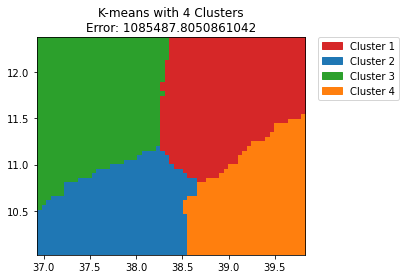

In [126]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, # Number of clusters to form
            init='k-means++', # Method for initialization: 
              # ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence, and is theoretically proven to be -optimal. See the description of n_init for more details.
            n_init=20, # Number of time the k-means algorithm will be run with different centroid seeds. Result is best output in terms of inertia
            max_iter=1000, # Maximum number of iterations of the k-means algorithm for a single run.
            tol=0.0001, #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
            verbose=0, # Verbosity mode
            random_state=0, 
            copy_x=True, 
            algorithm='full'# K-means algorithm to use. The classical EM-style algorithm is "full"
            )
        
kmeans.fit_predict(X)
cmap = ListedColormap(['tab:red','tab:blue','tab:green','tab:orange'])
labels = kmeans.labels_
im = plt.imshow(labels.reshape(w,h) ,
            cmap= cmap, 
            interpolation='None', extent = extent)
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title("K-means with 4 Clusters\nError: " + str(kmeans.inertia_))
plt.show()

# Run X means

In [21]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, tolerance=0.001)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

In [29]:
def plot_map2(labels):
    def get_extent(data_dict):
        x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
        y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
        extent = [x_min , x_max, y_min , y_max]
        return extent
    #labels = gmm.predict(X)
    im = plt.imshow(labels.reshape(w,h) , 
                interpolation='None', extent = get_extent(data_dict), cmap=plt.get_cmap('hsv'))
    # get the colors of the values, according to the 
    # colormap used by imshow
    values = np.unique(labels)
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.show()

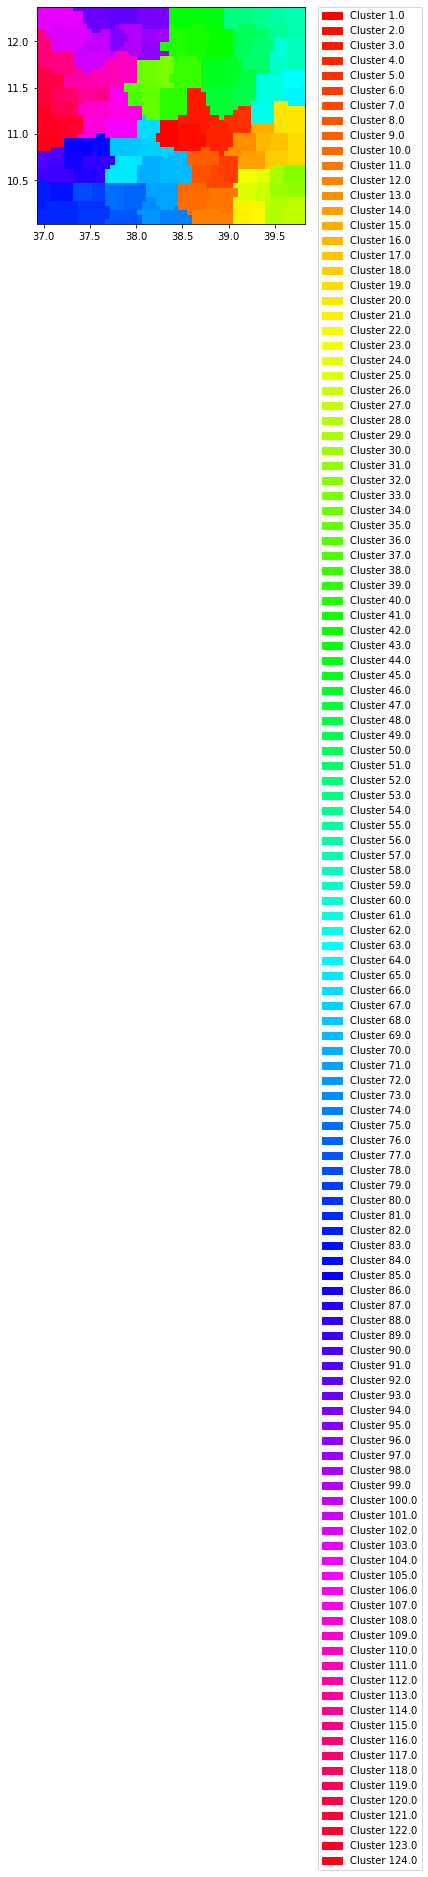

In [31]:
from pyclustering.cluster.xmeans import splitting_type

# see criteria at each split
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, 1000, tolerance = 0.001)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i
plot_map2(xmeans_labels)

0.7888297293362929


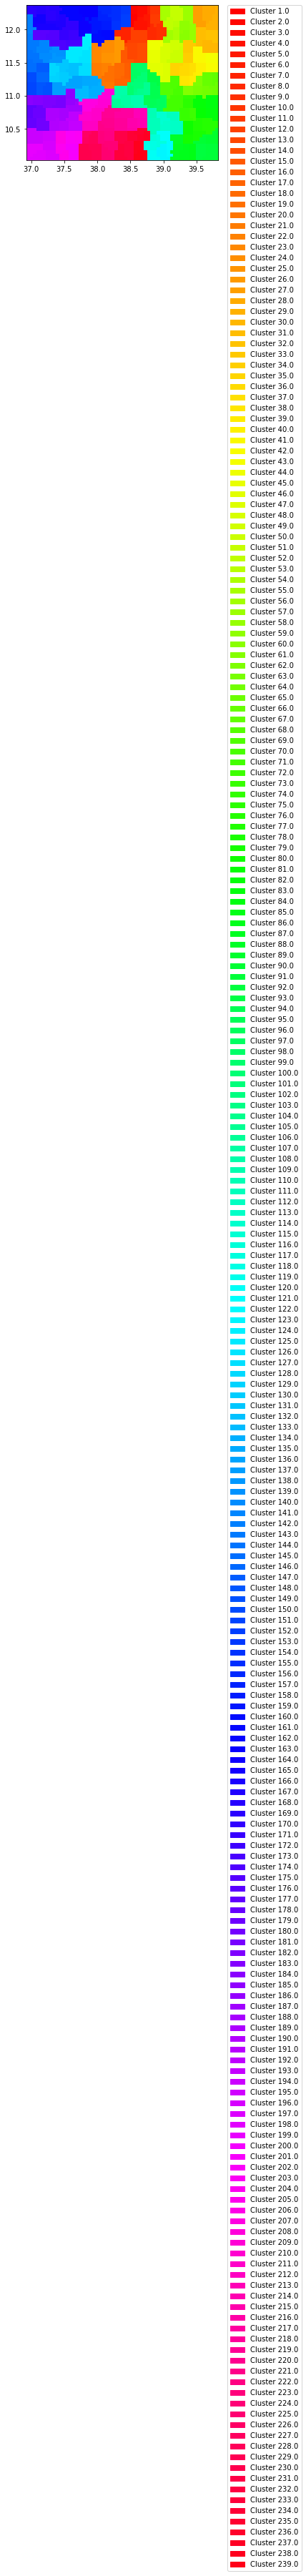

In [40]:
# run x-means on PCA
pca = PCA(n_components=20).fit(X)
print(sum(pca.explained_variance_ratio_))
X_pca = pca.transform(X)
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X_pca, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X_pca, initial_centers, 1000, tolerance = 0.001)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X_pca))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i
plot_map2(xmeans_labels)

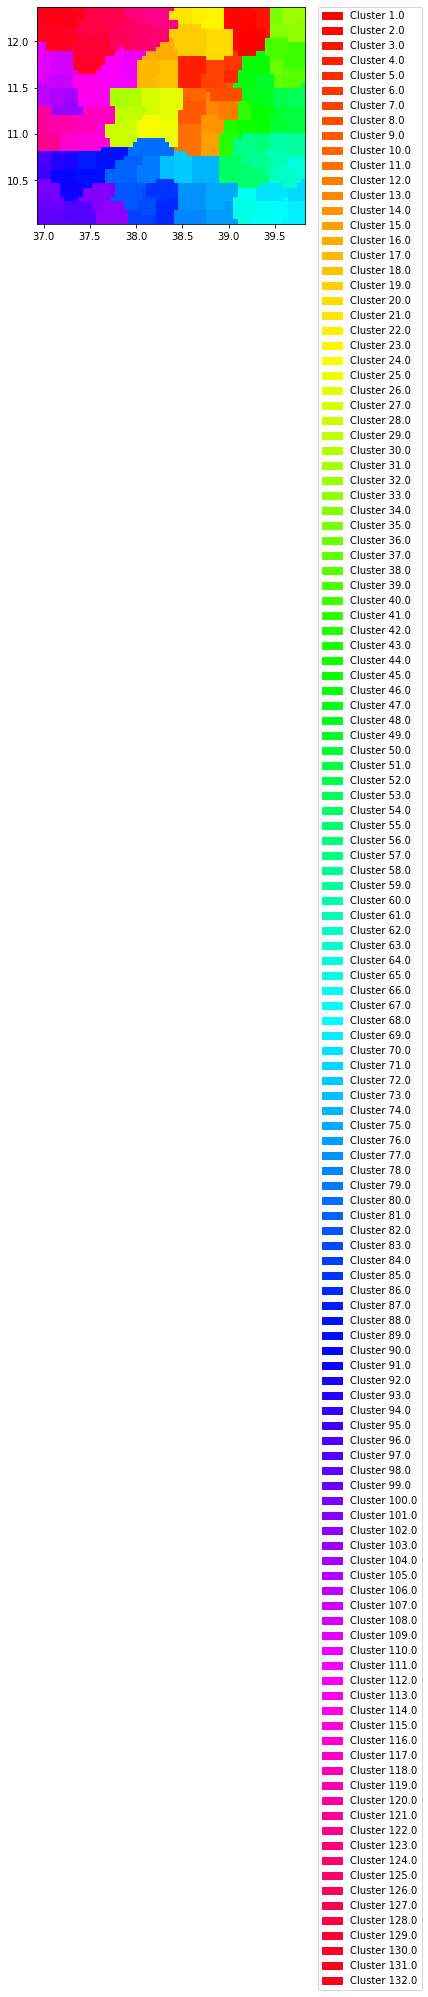

In [41]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X, initial_centers, 1000)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
xmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        xmeans_labels[idx] = i
plot_map2()

# Run PCA

In [120]:
from sklearn.decomposition import PCA
n_components = 4
pca = PCA(n_components=n_components).fit(X)
evr = pca.explained_variance_ratio_

In [121]:
pca = pca.transform(X)

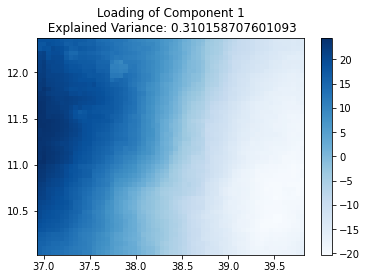

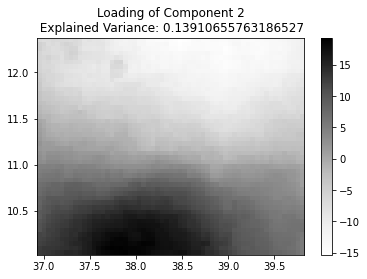

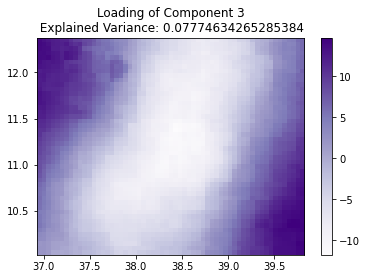

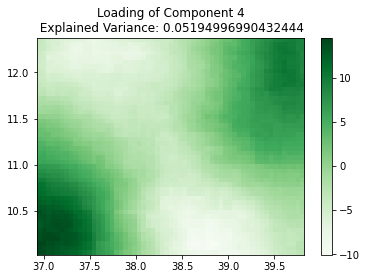

In [122]:
colors = ["Blues", "Greys", "Purples", "Greens"]
for i in range(n_components):
    labels = pca[:, i]
    im = plt.imshow(labels.reshape(w,h),
                cmap= colors[i], 
                interpolation='None', extent = extent)
    plt.title("Loading of Component " + str(i+1) + "\n Explained Variance: " + str(evr[i]))
    plt.colorbar()
    values = np.unique(labels)
    plt.show()

In [29]:
pca

array([[ 18.54944442,  -7.09967929,  13.64464381],
       [ 18.57518953,  -7.70466961,  13.01649333],
       [ 18.42534243,  -7.52656264,  12.48443103],
       ...,
       [-16.93308863,   6.76852844,  13.16608318],
       [-16.2678588 ,   5.99233431,  13.71911299],
       [-15.83819046,   5.16994052,  13.76903353]])

In [123]:
sum(evr)

0.5789615777901366

# Run G-Means

## 1. Run g-means with default settings

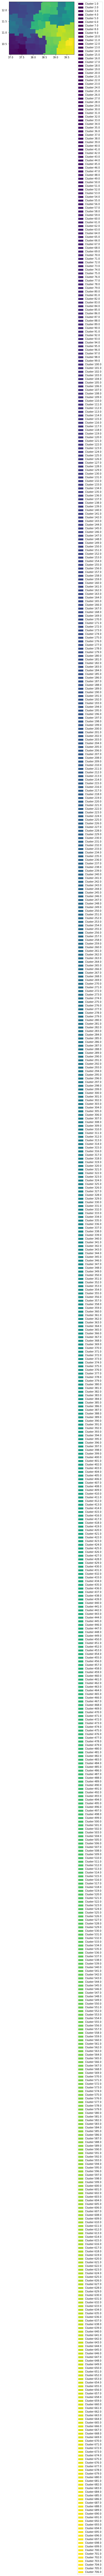

In [43]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.gmeans import gmeans

gmeans_instance = gmeans(X, repeat=5, tolerance=.0001).process()
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()
gmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        gmeans_labels[idx] = i

labels = gmeans_labels
im = plt.imshow(labels.reshape(w,h) , 
            interpolation='None', extent = extent)
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

0.7888296117556876


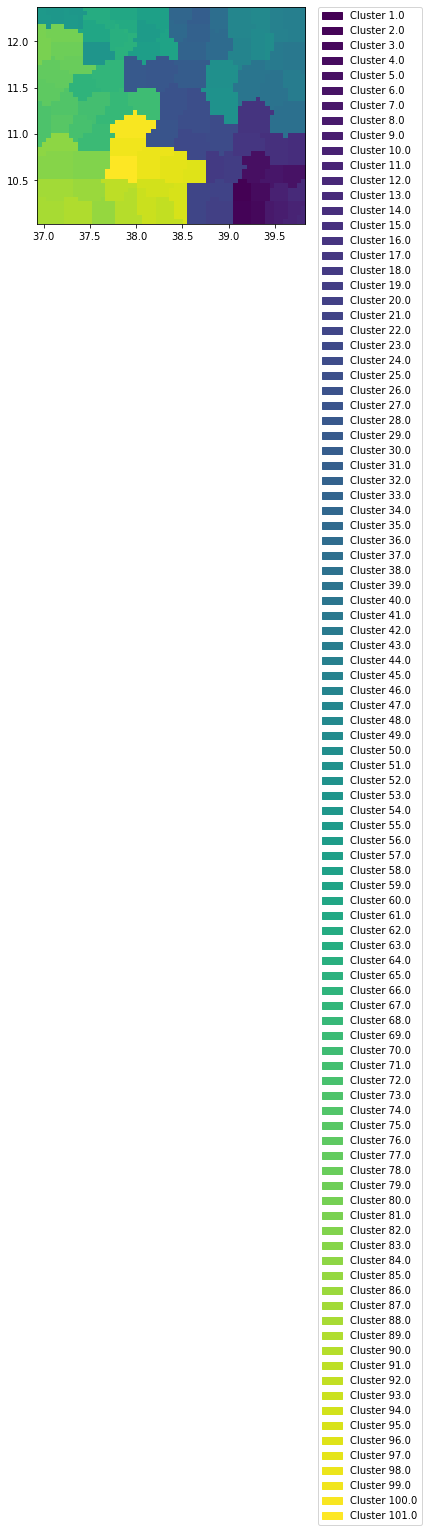

In [39]:
# g means with PCA
pca = PCA(n_components=20).fit(X)
print(sum(pca.explained_variance_ratio_))
X_pca = pca.transform(X)
gmeans_instance = gmeans(X_pca, repeat=5, tolerance=.0001).process()
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()
gmeans_labels = np.zeros(len(X_pca))
for i in range(len(clusters)):
    for idx in clusters[i]:
        gmeans_labels[idx] = i

labels = gmeans_labels
im = plt.imshow(labels.reshape(w,h) , 
            interpolation='None', extent = extent)
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

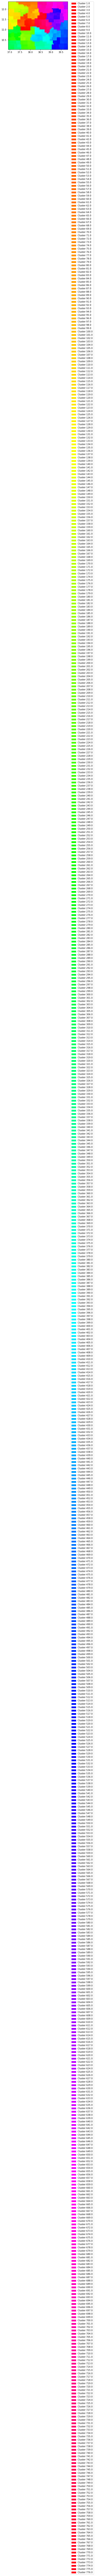

In [38]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.gmeans import gmeans

gmeans_instance = gmeans(X, repeat=5, tolerance=100000000000000).process()
# Extract clustering results: clusters and their centers
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()
gmeans_labels = np.zeros(len(X))
for i in range(len(clusters)):
    for idx in clusters[i]:
        gmeans_labels[idx] = i
        
def get_extent(data_dict):
    x_min, x_max = data_dict['longitude'].min(), data_dict['longitude'].max()
    y_min, y_max = data_dict['latitude'].min(), data_dict['latitude'].max()
    extent = [x_min , x_max, y_min , y_max]
    return extent
labels = gmeans_labels
#labels = gmm.predict(X)
im = plt.imshow(labels.reshape(w,h) , 
            interpolation='None', extent = get_extent(data_dict), cmap=plt.get_cmap('hsv'))
# get the colors of the values, according to the 
# colormap used by imshow
values = np.unique(labels)
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

# Analysis

## Plot PCA n-components vs. optimal k and error

In [ ]:
# find for pca=[10, 50, 100, 500, 1000, all] x-means k and error, g-means k and error
n_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, len(X[0])]
x_means_k = []
g_means_k = []
x_means_errors = []
g_means_errors = []
for n in n_components:
    X_pca = PCA(n_components=n).fit_transform(X)
    
    # run x means (requires initial centers)
    initial_centers = kmeans_plusplus_initializer(X_pca, 2).initialize()
    xmeans_instance = xmeans(X_pca, initial_centers, 1000, tolerance = .0001).process()
    x_means_k += [len(xmeans_instance.get_centers())]
    x_means_errors += [xmeans_instance.get_total_wce()]
    if n in [10, 100, 2006]:
        im = plt.imshow(labels.reshape(w,h) , 
                interpolation='None', extent = extent, cmap=plt.get_cmap('hsv'))
        plt.title("X-Means\nNumber of Components: " + str(n) + "\nK: " + str(len(xmeans_instance.get_centers())))
        values = np.unique(labels)
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
        plt.show()
    
    # run g means
    gmeans_instance = gmeans(X_pca, repeat=5, tolerance=.0001).process()
    g_means_k += [len(gmeans_instance.get_centers())]
    g_means_errors += [gmeans_instance.get_total_wce()]
    if n in [10, 100, 2006]:
        gmeans_labels = np.zeros(len(X_pca))
        for i in range(len(clusters)):
            for idx in clusters[i]:
                gmeans_labels[idx] = i
        labels = gmeans_labels
        im = plt.imshow(labels.reshape(w,h), 
                    interpolation='None', extent = extent, cmap=plt.get_cmap('hsv'))
        plt.title("G-means\nNumber of Components: " + str(n) + "\nK: " + str(len(gmeans_instance.get_centers())))
        values = np.unique(labels)
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Cluster {l}".format(l=values[i] +1) ) for i in range(len(values)) ]
        plt.show()

In [ ]:
plt.plot(n_components, x_means_k, label="X-means")
plt.plot(n_components, g_means_k, label="G-means")
plt.xlabel("Number of Components PCA")
plt.ylabel("k")
plt.legend()
plt.show()

In [ ]:
plt.plot(n_components, x_means_errors, label="X-means")
plt.plot(n_components, g_means_errors, label="G-means")
plt.xlabel("Number of Components PCA")
plt.ylabel("error")
plt.legend()
plt.show()

In [64]:
print(x_means_errors)

[12814.86722598377, 37165.97792976233, 57597.345216282854, 197875.03651108305, 240598.2486702623, 238481.11773875591]


In [65]:
print(g_means_errors)

[37050.89066038951, 65970.26999013787, 64674.51645320987, 89584.36489923758, 101793.16039992434, 97047.03229828215]


In [66]:
len(X[0])

2006

In [ ]:
plt.scatter(x_means_k, x_means_errors, label="x-means")
plt.scatter(g_means_k, g_means_errors, label="g-means")
plt.xlabel("k")
plt.ylabel("error")
plt.legend()
plt.show()

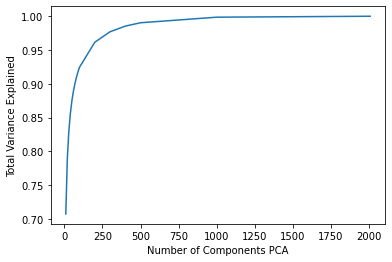

In [127]:
n_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, len(X[0])]
explained_var = []
for n in n_components:
    pca = PCA(n_components=n).fit(X)
    explained_var.append(sum(pca.explained_variance_ratio_))
plt.plot(n_components, explained_var)
plt.xlabel("Number of Components PCA")
plt.ylabel("Total Variance Explained")
plt.show()

In [130]:
min(x_means_k)

141

In [131]:
max(x_means_k)

456

In [132]:
min(g_means_k)

86

In [133]:
max(g_means_k)

733

In [134]:
len(g_means_k)

16